In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from functools import reduce
from torchvision import datasets, transforms

import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

## Dades

Emprarem el dataset **EMNIST**. És un conjunt de dígits de caràcters escrits a mà derivats de la base de dades del NIST 19 i convertits a un format d'imatge seguint una estructura que coincideix directament amb el conjunt de dades del MNIST. Aquest conjunt de dades presenta múltiples subconjunts nosaltres en primer lloc emprarem el dels _digits_. [Documentacio](https://pytorch.org/vision/main/generated/torchvision.datasets.EMNIST.html)



Cada un dels elements del dataset és una imatge de 28x28 pixels i pot ser de 47 classes diferents. La descripció és al següent article: [enllaç](https://arxiv.org/pdf/1702.05373v1.pdf)
La càrrega i preparació de les dades segueix la mateixa estructura que quan fèiem aprenentatge emprant SVM, afegint una passa més, la creació de subconjunts d'entrenament (també coneguts com _mini-batches_).

1. Càrrega de dades.
2. Estandarització.
3. Creació de grups d'entrenament.


In [16]:
# Definim una seqüència (composició) de transformacions
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # mitjana, desviacio tipica (precalculats)
    ])

# Descarregam un dataset ja integrat en la llibreria Pytorch:
train = datasets.EMNIST('data', split="digits", train=True, download=True, transform=transform)  ## Si acabau podeu fer proves amb el split "balanced"
test = datasets.EMNIST('data', split="digits",train=False, transform=transform)

Com és un dataset? Quina estructura té?

In [17]:
print("Info:")
print("Tipus de la variable train : ", type(train)) # la variable test te les mateixes característiques
print(test.__dict__.keys()) ## Tot objecte Python té un diccionari amb els seus atributs
classes = test.classes ## Obtenim una llista amb les classes del dataset
print(f"{classes = }")

Info:
Tipus de la variable train :  <class 'torchvision.datasets.mnist.EMNIST'>
dict_keys(['split', 'training_file', 'test_file', 'root', 'transform', 'target_transform', 'transforms', 'train', 'data', 'targets', 'classes'])
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


És molt important entendre com és l'estructura dels conjunts que necessitam per fer feina amb la xarxa.
La classe `DataLoader` rep un conjunt de dades i una mida de `batch`, i ens proporciona un iterable sobre aquest.

In [18]:
train_batch_size = 64
test_batch_size = 100

# Transformam les dades en l'estructura necessaria per entrenar una xarxa
train_loader = torch.utils.data.DataLoader(train, train_batch_size)
test_loader = torch.utils.data.DataLoader(test, test_batch_size)



A continuació cream un iterador sobre el nostre conjunt d'entrenament, això ens torna un _batch_.
Mostrarem la primera imatge juntament amb la seva etiqueta. Després mostram informació referent al _batch_.

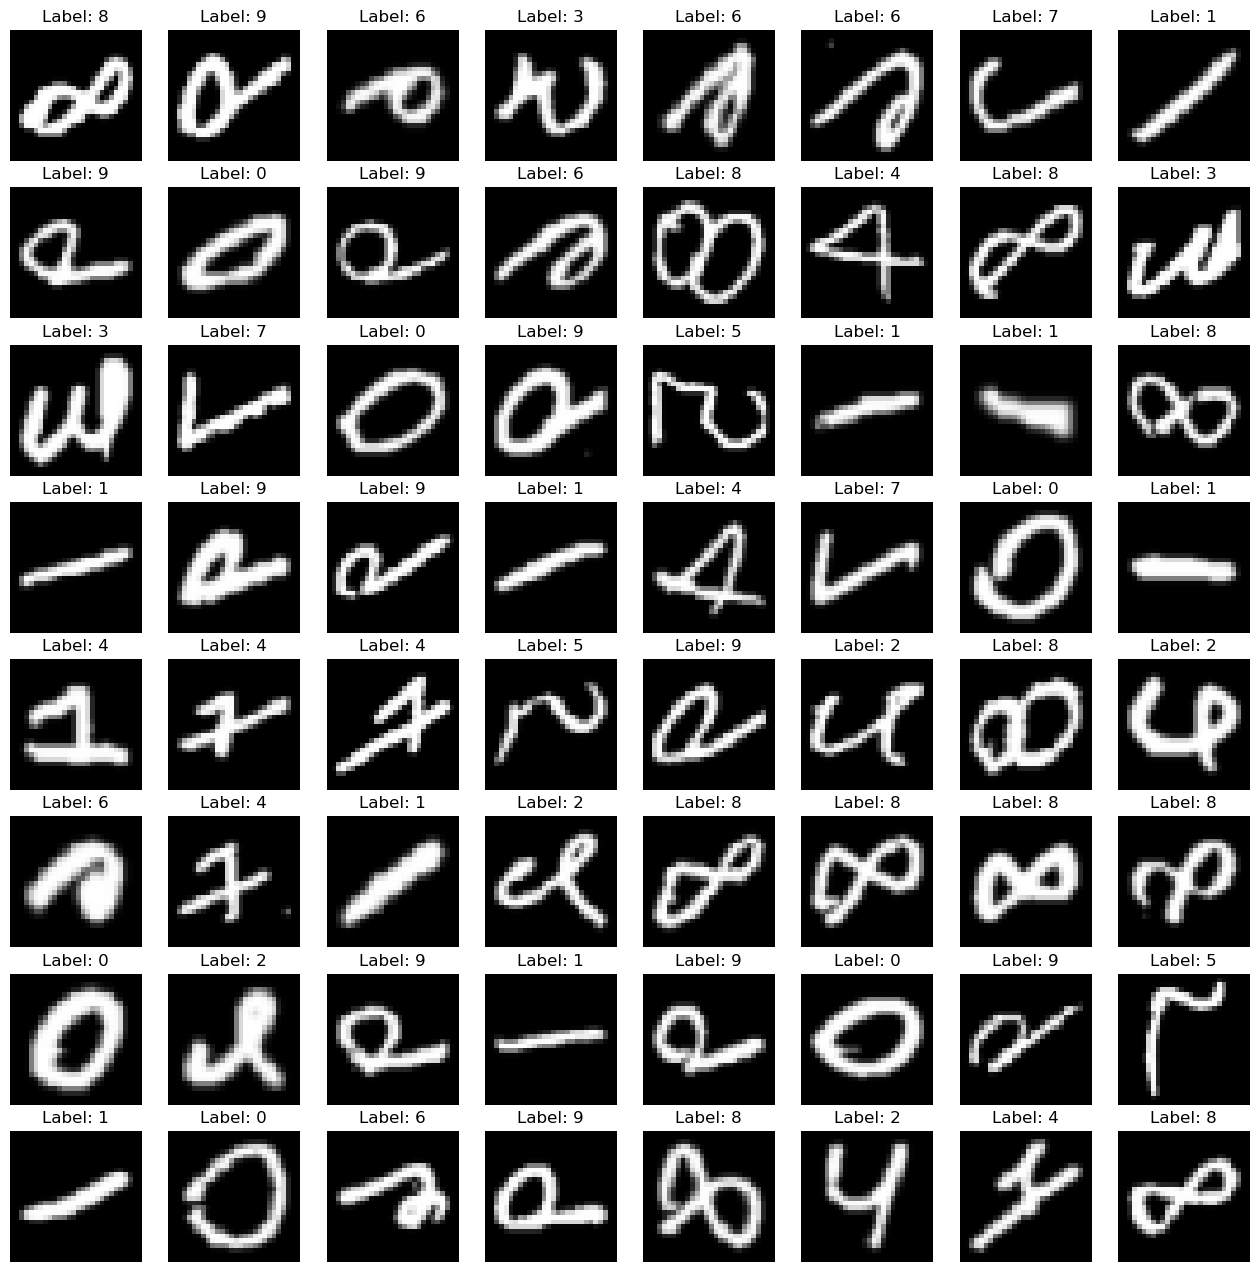

In [19]:
features, labels = next(iter(train_loader))


def show_images(images, labels):
    n_images = len(images)
    fig, axs = plt.subplots(
        int(n_images**0.5),
        int(n_images**0.5),
        figsize=(n_images // 4, n_images // 4),
    )
    axs = axs.flatten()

    for image, label, ax in zip(images, labels, axs):
        ax.imshow(image.reshape(*image.shape[-2::]), cmap="gray")
        ax.set_title(f"Label: {label}")
        ax.axis("off")
    plt.show()


show_images(*next(iter(train_loader)))

## Definició de la xarxa
Cma ja sabem (almanco ens sona de la classe anterior) emprant el mòdul `nn` de _Pytorch_ podem definir la nostra pròpia xarxa, en aquesta pràctica realitzarem una classe que la contengui, això ens dona més llibertat i flexibilitat.

Crearem una classe filla de `nn.Module` on com a mínim hi definirem dos mètodes:

  - Constructor: mètode `__init__` en el que definim les capes de la nostra xarxa.
  - `forward`: mètode en el qual definim com és el flux de la informació. Aquí podem afegir capes no entrenables, per exemple una `ReLu`.

La xarxa que heu de crear és una xarxa densa, per tant, totes les capes seran linears: `nn.Linear`. On la darrera capa ha de tenir una dimensionalitat igual al nombre de classes que volem predir.

Com a sortida és recomanable usar la funció _softmax_ que converteix un vector de $K$ nombres reals en una distribució de probabilitat de $K$ possibles resultats. És una generalització de la funció logística a múltiples dimensions, i s'utilitza en regressió logística multinomial. La funció _softmax_ s'utilitza sovint com l'última funció d'activació d'una xarxa neural per normalitzar la seva sortida a una distribució de probabilitat sobre les classes de sortida predites. Es calcula de la següent manera:

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/ab3ef6ba51afd36c1d2baf06540022053b2dca73"
     alt="Softmax"
     style="float: left; margin-right: 10px;" />





In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = torch.nn.Linear(784, 400)
        self.l2 = torch.nn.Linear(400, 200)
        self.l3 = torch.nn.Linear(200, 100)
        self.l4 = torch.nn.Linear(100, 10)  # Last layer with target = amount of classes

    def forward(self, x):
        layer_order = [
            lambda x: torch.flatten(x, 1),
            self.l1,
            torch.nn.ReLU(),
            self.l2,
            torch.nn.ReLU(),
            self.l3,
            torch.nn.ReLU(),
            self.l4,
            lambda x: F.softmax(x, dim=1),
        ]

        return reduce(lambda acc, fun: fun(acc), layer_order, x)

## Entrenament

Les bones pràctiques de programació ens diuen que cal organitzar el codi en funcions. En definirem una per la passa d'entrenament i una altra per la fase de test.

En aquesta fase s'ha de definir la funció de pèrdua, recordau que aquesta és la funció que avalua la diferència entre el que ha predit la xarxa i la sortida desitjada. Existeixen múltiples funcions de pèrdua que emprarem segons el problema a resoldre i les seves particularitats. Per exemple en el problema de regressió de la setmana passada vàrem emprar l'error absolut al quadrat (_MSE_).

Nosaltres emprarem: **cross entropy** que prové de la teoria de la informació de _Shannon_ i que vé a explicar que l'entropia d'una variable aleatòria és el nivell mitjà d'informació / sorpresa / incertesa inherent als possibles resultats d'aquesta variable. La fórmula és la següent:

$ LCE = -∑_{i=1}^M t_i \log(p_i)$

On $M$ és el nombre de classes, $t_i$ és un valor binari indicant si l'observació és d'aquesta classe (valor 1 si ho és i valor 0 en cas contrari) i $p_i$ és el resultat de la funció _Softmax_ per aquesta classe.

In [21]:
def train(model, device, train_loader, optimizer, epoch, loss_fn, log_interval=100, verbose=True):

    model.train() # Posam la xarxa en mode entrenament

    loss_v = 0 # Per calcular la mitjana (és la vostra)

    # Bucle per entrenar cada un dels batches
    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data.to(device), target.to(device)  ###  Veure ús de CuDA en cel·les inferiors
        optimizer.zero_grad()
        output = model(data)
        loss =  loss_fn(output, target)
        loss.backward()

        optimizer.step()

        ## Informació de debug
        if batch_idx % log_interval == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Average: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), loss.item()/ len(data)))
        loss_v += loss.item()

    loss_v /= len(train_loader.dataset)
    print(f'\n Epoch {epoch} Train set: Average loss: {loss_v}')

    return loss_v


def test(model, device, test_loader,loss_fn):
    model.eval() # Posam la xarxa en mode avaluació

    test_loss = 0
    correct = 0

    with torch.no_grad(): # desactiva el càlcul de gradients, no ho necessitam per l'inferència. Estalvia memòria i fa més ràpids els càlculs
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss +=  loss_fn(output, target)
            pred = output.argmax(dim=1, keepdim=True)  # index amb la max probabilitat
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Informació de debug
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return test_loss

A continuació definim els paràmetres d'entrenament i el bucle principal:

In [25]:
torch.manual_seed(33)

# El següent ens permet emprar l'entorn de cuda. Si estam emprant google colab el podem activar a "Entorno de ejecución"
use_cuda = False
if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Paràmetres bàsics
epochs = 10
lr = 1e-4
model = Net().to(device)

# Stochastic gradient descent
optimizer = optim.SGD(model.parameters(), lr=lr)

# Guardam el valor de pèrdua mig   de cada època, per fer el gràfic final
train_l = np.zeros((epochs))
test_l = np.zeros((epochs))

loss_fn = nn.CrossEntropyLoss(reduction="sum")

# Bucle d'entrenament
for epoch in range(0, epochs):
    train_l[epoch] = train(
        model, device, train_loader, optimizer, epoch, loss_fn, verbose=False
    )
    test_l[epoch] = test(model, device, test_loader, loss_fn)

AssertionError: Torch not compiled with CUDA enabled

Mostram la gràfica resultat de l'entrenament

In [ ]:
plt.title("Resultats de l'entrenament")
plt.plot(range(1, (epochs + 1)), train_l,  c="red", label="train")
plt.plot(range(1,  (epochs + 1)), test_l,  c="green", label="test")
plt.legend();

Avaluam amb una mètrica objectiva (_accuracy_)

Per fer això hem de recorrer tots els _batch_ del conjunt de test i avaluar-los. Finalment empram la mètrica ja coneguda de la llibreria _sklearn_ per calcular-la:

In [ ]:
from sklearn.metrics import accuracy_score

model.eval() # Posam la xarxa en mode avaluació

targets = []
predictions = []

with torch.no_grad(): # desactiva el càlcul de gradients, no ho necessitam per l'inferència. Estalvia memòria i fa més ràpids els càlculs
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # index amb la max probabilitat
        targets.extend(target.tolist())
        predictions.extend(torch.flatten(pred.cpu()).tolist())
        
targets = np.asarray(targets)
predictions = np.asarray(predictions)

print(f"Accuracy: {accuracy_score(targets, predictions)}")